### Loading

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.segmentation import detect_iris, detect_pupil_with_circle, bounding_box_segmentation, evaluate_segmentation

In [2]:
import torch
import torchvision.transforms as T
from segment_anything import SamPredictor, sam_model_registry
import SimpleITK as sitk

In [3]:
image = cv2.imread("dataset/openEDS/openEDS/S_0/21.png") 
img_gt = np.load("dataset/openEDS/openEDS/S_0/21.npy")

In [5]:
gray, blurred, edges, iris_center, iris_radius = detect_iris(image)

Iris detected successfully.


circles [[364 250  17]]
Pupil detected successfully.


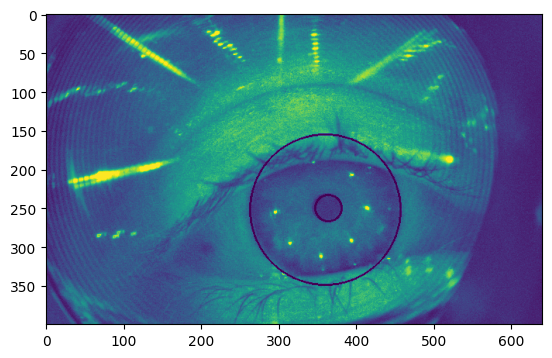

In [7]:
def detect_pupil_with_circle(gray, binary_mask, iris_center, iris_radius):
    # Step 1: Create a circular mask based on the detected iris
    mask_shape = binary_mask.shape
    iris_mask = np.zeros(mask_shape, dtype=np.uint8)
    cv2.circle(iris_mask, iris_center, iris_radius, 255, thickness=-1)
    # Step 2: Apply the iris mask to the binary mask
    masked_binary = cv2.bitwise_and(binary_mask, iris_mask)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    masked_binary = clahe.apply(masked_binary)
    edges = cv2.Canny(masked_binary, threshold1=600, threshold2=400)# 130 200
    kernel = np.ones((5,5),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)
    #plt.imshow(masked_binary)
    #plt.show()

    circles = cv2.HoughCircles(edges, 
                               cv2.HOUGH_GRADIENT, 
                               dp=1, 
                               minDist=30, 
                               param1=10, 
                               param2=3+10, 
                               minRadius=5, 
                               maxRadius=100)
    #circles = remove_overlapping_circles(circles)
    #print("circles ", circles)
    #plt.imshow(edges)
    #plt.show()
    # Step 7: Draw detected circles (iris) on the original image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        print('circles', circles[0])
        ##rr = [r for _, _, r in circles[0]]
        #index = np.argmax(rr)
        #circle = circles[index]
        #circles = [circle]
        for i in circles[0]: #[0, :]
            # Draw the outer circle
            cv2.circle(gray, (i[0], i[1]), i[2], (0, 0, 255), 2)
            # Save the iris center for pupil detection
            pupil_center = (i[0], i[1])
            pupil_radius = i[2]
        print("Pupil detected successfully.")
    else:
        print("No pupil detected.")
        return
    return gray, pupil_center, pupil_radius
_, binary_mask = cv2.threshold(image[:,:,2], 45, 100, cv2.THRESH_BINARY_INV)
g, pupil_center, pupil_radius = detect_pupil_with_circle(gray, binary_mask, iris_center, iris_radius)
plt.imshow(g)
plt.show()

In [8]:
# Load the SAM model
model_type = "vit_b" 
model_path = "models/sam_vit_b_01ec64.pth" 

sam = sam_model_registry[model_type](checkpoint=model_path)
sam.eval()
predictor = SamPredictor(sam)
predictor.set_image(image)

c:\Users\hohih\optimeyes\venv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


1


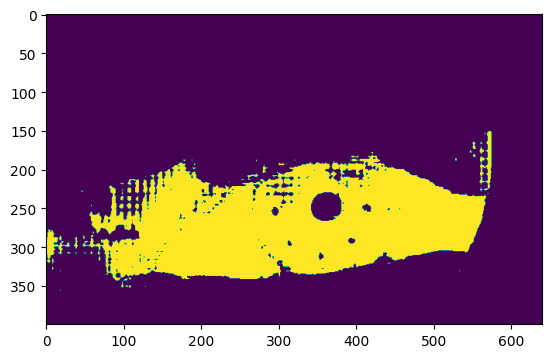

In [9]:
def bounding_box_segmentation(image, predictor):
    # Estimate eye location (you may need to adjust these values)
    h, w = image.shape[:2]
    
    ################
    #input_point = np.array([[250//5, 300//5]])
    #input_label = np.array([1])
    point_coords = np.array([[250, 310], [500, 250], [250, 250]])  # Replace with actual coordinates
    point_labels = np.array([1, 1, 1])  # All are foreground points

    # Optional: Add background points
    background_coords = np.array([[350,150], [350, 370],[150,350]])  # Outside the sclera
    background_labels = np.array([0, 0, 0])

    # Combine the points
    point_coords = np.concatenate((point_coords, background_coords), axis=0)
    point_labels = np.concatenate((point_labels, background_labels), axis=0)

    masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    multimask_output=False  # Generate multiple segmentation masks
    )
    best_mask_index = np.argmax(scores)  # Choose the mask with the highest score
    sclera_mask = masks[best_mask_index]
    print(len(masks))
    ################
    #box = np.array([100, 600, 150, 350]) #[w*0.2, h*0.2, w*0.8, h*0.8])
    #masks, _, _ = predictor.predict(box=box[None, :], multimask_output=False)
    return sclera_mask
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Apply histogram equalization
enhanced_image = cv2.equalizeHist(gray_image)
# Convert the grayscale image back to a 3-channel image
enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
predictor.set_image(enhanced_image_rgb)
box_mask = bounding_box_segmentation(enhanced_image_rgb, predictor)
plt.imshow(box_mask)
plt.show()

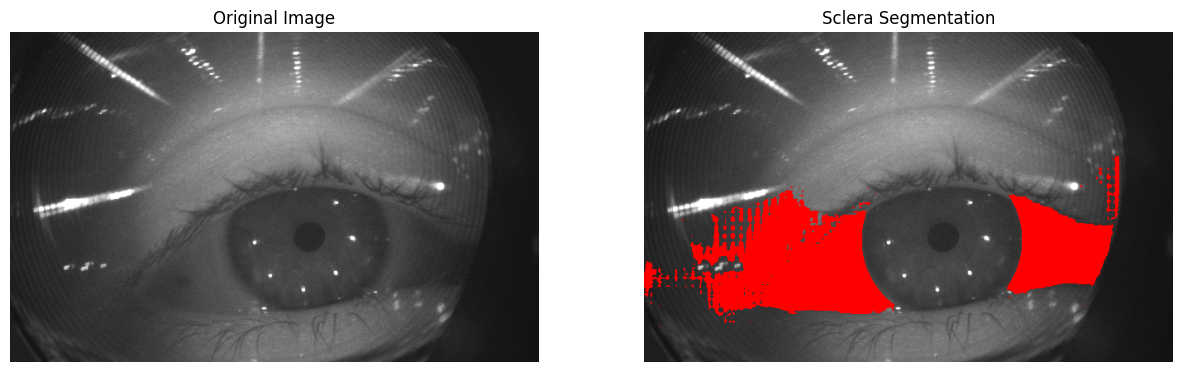

In [10]:
# Filter out contours inside the iris region
iris_mask = np.zeros_like(gray)
cv2.circle(iris_mask, iris_center, iris_radius, 255, thickness=-1)
# Step 2: Apply the iris mask to the binary mask
no_iris_mask = cv2.bitwise_not(iris_mask)
no_iris_image = cv2.bitwise_and(gray, no_iris_mask)

final_sclera_mask = cv2.bitwise_and(box_mask.astype(np.uint8), no_iris_mask)

# Create a copy of the original image for visualization
segmented_image = image.copy()
# Apply the mask to the image
segmented_image[final_sclera_mask == 1] = [255, 0, 0]  # Color the mask area red for visualization
# Plot the original image and the segmented result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(segmented_image)
ax2.set_title("Sclera Segmentation")
ax2.axis("off")

plt.show()


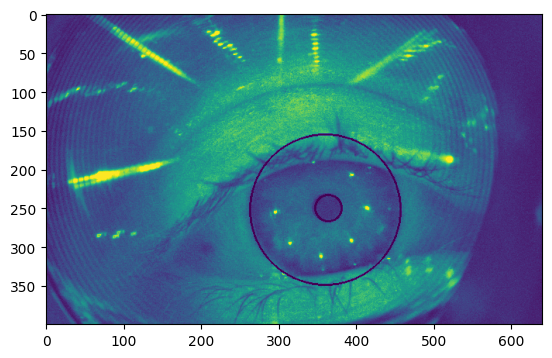

In [11]:
plt.imshow(gray)
plt.show()

### Histogram visualization

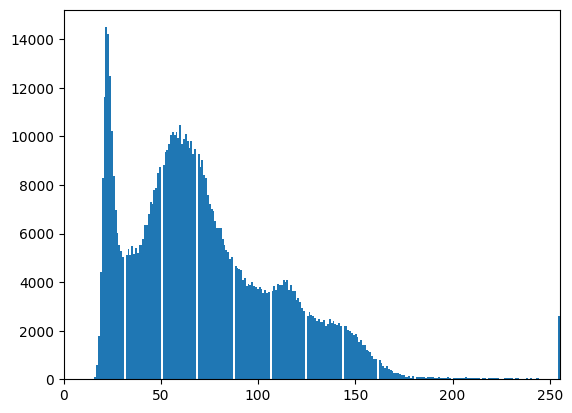

In [12]:
b, bins, patches = plt.hist(image.flatten(), 255)
plt.xlim([0,255])
plt.show()

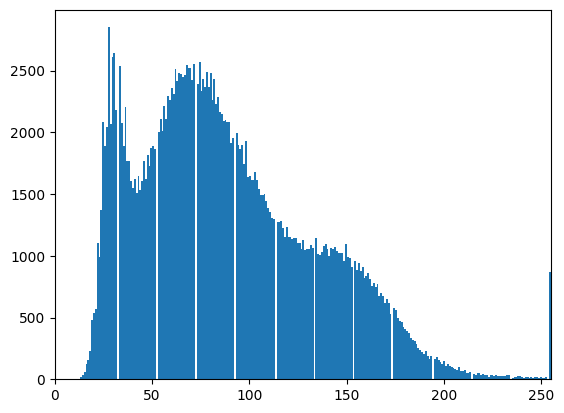

In [13]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_d = clahe.apply(gray)
b, bins, patches = plt.hist(image_d.flatten(), 255)
plt.xlim([0,255])
plt.show()

### Segmentation result and evaluation

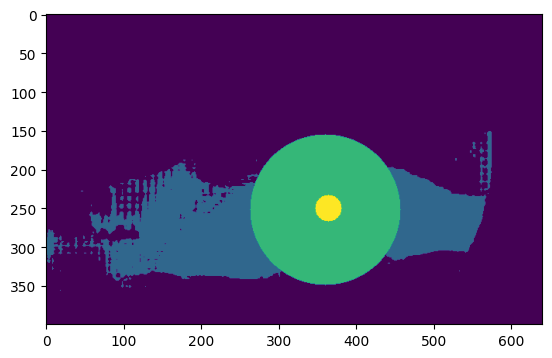

In [14]:
pred_img_shape = gray.shape
pred_img = np.zeros(pred_img_shape, dtype=np.uint8)
cv2.circle(pred_img, iris_center, iris_radius, 2, thickness=-1)
cv2.circle(pred_img, pupil_center, pupil_radius, 3, thickness=-1)
pred_img[final_sclera_mask == 1] = 1

plt.imshow(pred_img)
plt.show()

In [15]:
from collections import Counter
flat_img = pred_img.flatten()
coun = Counter(flat_img)
coun

Counter({0: 193450, 1: 33025, 2: 28624, 3: 901})

In [16]:
metrics = evaluate_segmentation(pred_img, img_gt)

Segmentation metrics per class:
class_0:
  IOU: 0.8978
  dice: 0.9462
  acc: 0.9142
class_1:
  IOU: 0.4946
  dice: 0.6619
  acc: 0.9333
class_2:
  IOU: 0.7891
  dice: 0.8821
  acc: 0.9764
class_3:
  IOU: 0.7738
  dice: 0.8725
  acc: 0.9990


### extra

In [ ]:
def detect_and_plot_circle(edges):
    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        edges, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, 
        minDist=30, 
        param1=10, #50 
        param2=10, #30 
        minRadius=0, 
        maxRadius=0
    )

    # If some circles are detected, proceed to plot
    if circles is not None:
        # Convert the (x, y, radius) representation to integers
        circles = np.round(circles[0, :]).astype("int")
        # Draw the circles on a copy of the edges image for visualization
        output = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

        # Plot each circle
        for (x, y, r) in circles:
            # Draw the circle in the output image
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
            # Draw a small dot in the center
            cv2.circle(output, (x, y), 2, (0, 0, 255), 3)

        # Plotting the result with matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(output, cmap='gray')
        plt.title("Detected Circle")
        plt.axis("off")
        plt.show()

    else:
        print("No circles detected")


# Assuming 'edges' is your edge-detected numpy array
detect_and_plot_circle(edges)